In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

# 📦 Import packages

In [2]:
import cv2
import matplotlib.pyplot as plt
import pathlib
import os
import random

import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

tf.__version__

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

'2.12.0'

# 🔧 Useful Functions

In [3]:
def metrics2dt(acc, rc, pr, f1):
    return pd.DataFrame(data={"Accuracy":acc, "Recall":rc, "Precision":pr, "F1-Score":f1}, index=[0])

def show_metrics(y_true, y_pred):
    recall = tf.keras.metrics.Recall()
    precision = tf.keras.metrics.Precision()
    accuracy = tf.keras.metrics.Accuracy()

    recall.update_state(y_true, y_pred)
    recall = recall.result().numpy()
    
    precision.update_state(y_true, y_pred)
    precision = precision.result().numpy()
    
    accuracy.update_state(y_true, y_pred)
    accuracy = accuracy.result().numpy()
    
    f1_score = 0
    if recall+precision != 0:
        f1_score = 2 * ((recall*precision)/(recall+precision))
    
    return metrics2dt(accuracy, recall, precision, f1_score)

def plot_history(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# 🧠 About the [Brain MRI Images for Brain Tumor Detection](https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection):
This dataset contain a series Magenetic Resonance Imaging (MRI). According to [NCBI's article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6111434/), there are different types of MRI scans depending on the axial angle at which the MRI was performed. The angle of “axial” MR images is vertical to the bed of the equipment but with the development of oblique imaging, “axial” has come to mean a range of angles. The images from different angles demonstrate different appearances and relationships of structures. However, we can separate in two groups:

- The images through the orbits.

![image](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6111434/bin/10.1177_1971400918769911-fig2.jpg)

- The images at the parietal region.

![image](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6111434/bin/10.1177_1971400918769911-fig3.jpg)

Our dataset contain majority image at the paretial region, as we will see below, unfortunately I can't tell exactly wich line.


# 🔎 Viewing images

In [4]:
for root, dirs, files in os.walk("/kaggle/input/brain-mri-images-for-brain-tumor-detection/no", topdown=False):
    img_no = files
    
for root, dirs, files in os.walk("/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes", topdown=False):
    img_yes = files

## 😊 Normal brain

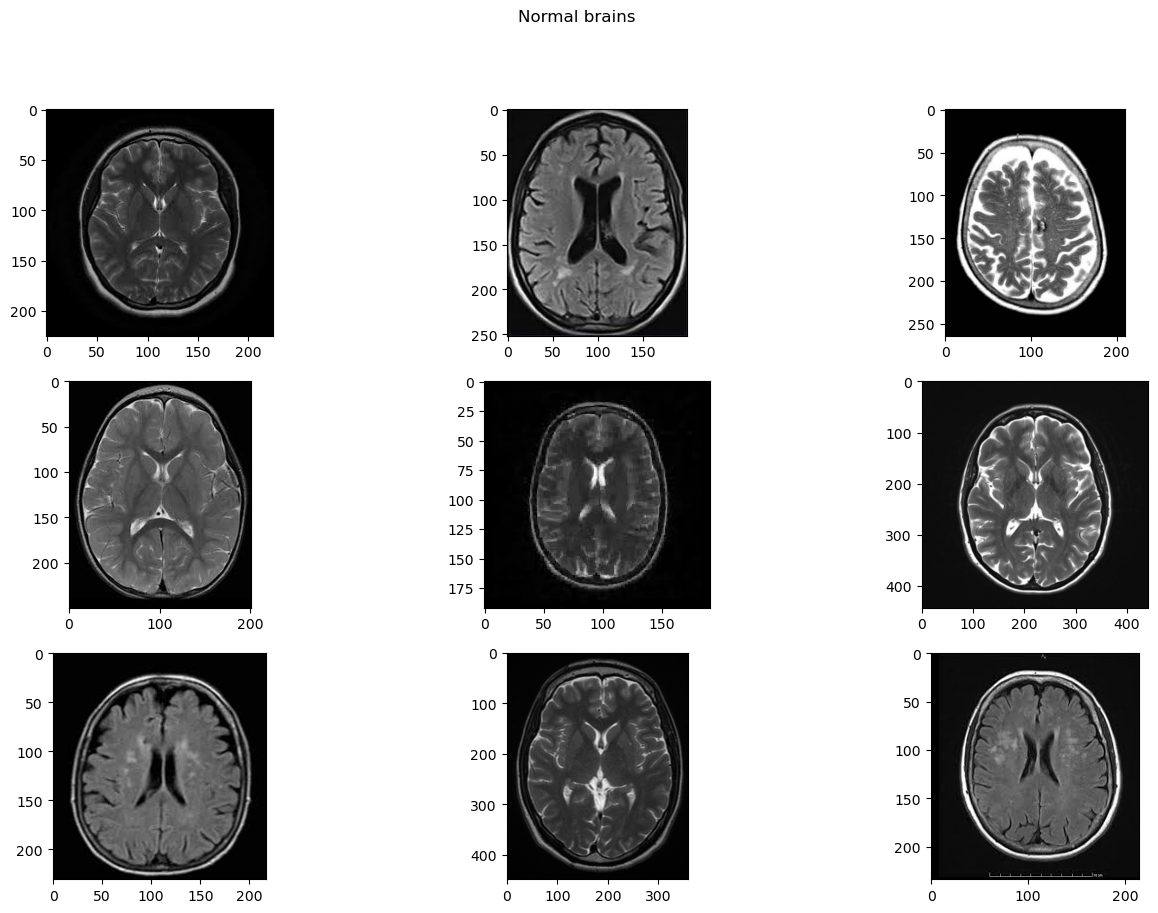

In [5]:
fig = plt.figure(figsize=(16, 10))
fig.suptitle('Normal brains')
x = 10
for i, filename in enumerate(img_no[0+x:9+x]):
    ax = plt.subplot(3, 3, i + 1)
    img = cv2.imread("/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/"+filename)
    plt.imshow(img)

## 🤕 Brain tumor

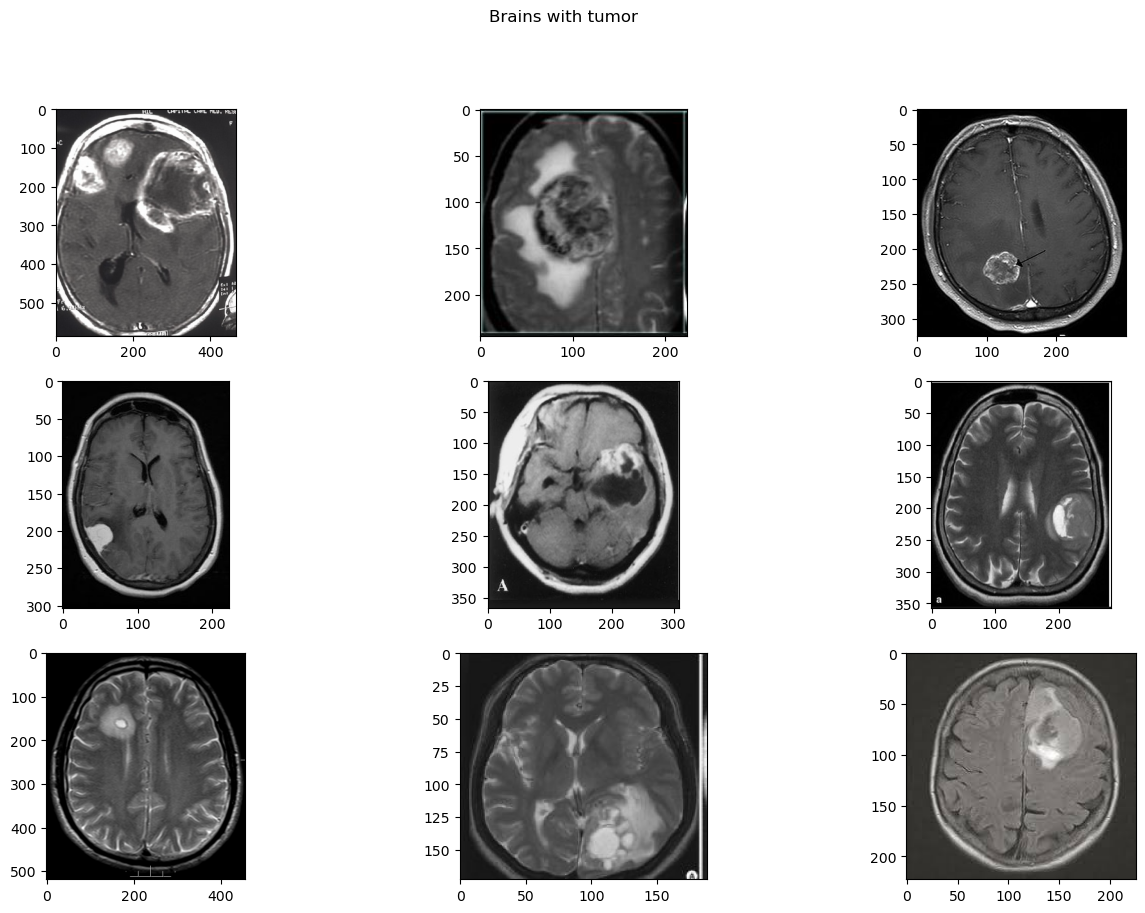

In [6]:
fig = plt.figure(figsize=(16, 10))
fig.suptitle('Brains with tumor')
x = 10
for i, filename in enumerate(img_yes[0+x:9+x]):
    ax = plt.subplot(3, 3, i + 1)
    img = cv2.imread("/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/"+filename)
    plt.imshow(img)

# 💻 Creation of training and validation dataset from images

We have two folders with MRI images where these images have been separated into 'yes' or 'no' class depending on whether the MRI image shows a brain tumor or not.

## Setting seeds to reproducibility

In [7]:
tf.random.set_seed(42)
np.random.seed(42)

In [8]:
image_dir = pathlib.Path("/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset")

train_dt, val_dt = image_dataset_from_directory(
    directory = image_dir,
    batch_size = 32,
    image_size = (224, 224),
    subset = "both",
    validation_split = 0.2,
    seed = 42)

Found 253 files belonging to 2 classes.
Using 203 files for training.
Using 50 files for validation.


Thus, we have a training dataset with 203 images and a validation dataset with 50 images. We haven't a large training dataset.

## Class names starting of directories tree

In [9]:
class_names = train_dt.class_names
print(class_names)

['no', 'yes']


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dt = train_dt.cache().prefetch(buffer_size=AUTOTUNE)
val_dt = val_dt.cache().prefetch(buffer_size=AUTOTUNE)

# 🤖 Creating and training my own deep learning model with preprocess layers to data augmentation:

All hyperparameters were obtained of experimental way.

### Looking for the better learning rate

In [11]:
model = tf.keras.Sequential(layers=[
    # Data augmentation
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomZoom(0.05, 0.05),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),
    ######
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, activation="relu"),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=(1,1), padding="valid"),

    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=(1,1)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation="relu"),

    tf.keras.layers.Dense(2, activation="softmax")
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

epochs = 100     
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))
  
history = model.fit(train_dt,
                  epochs=epochs,
                  steps_per_epoch=len(train_dt),
                  callbacks=[lr_scheduler],
                  verbose=0)

### Viewing the loss vs the learning rate

Text(0, 0.5, 'Loss')

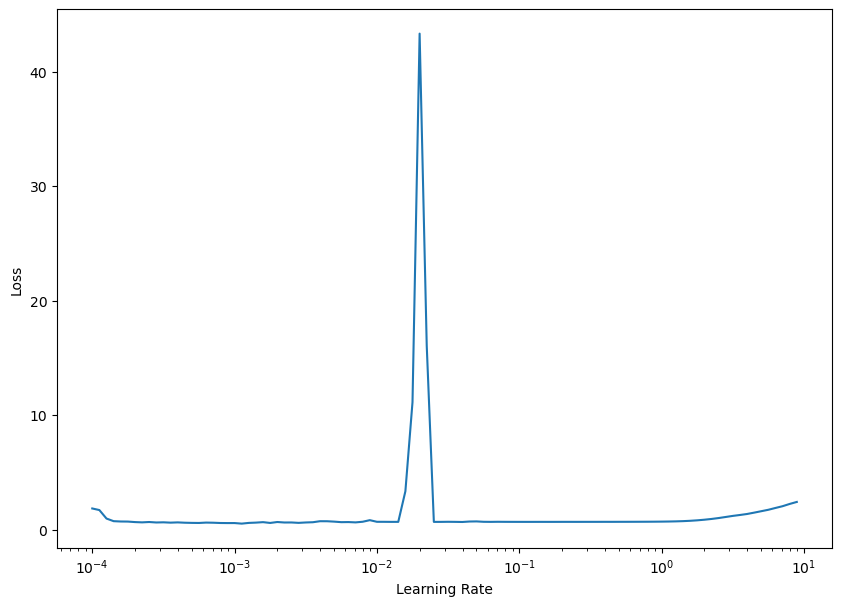

In [12]:
lrs = 1e-4 * (10 ** (np.arange(epochs)/20))
plt.figure(figsize=(10,7))
plt.semilogx(lrs, history.history['loss'])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')

In [13]:
minimum = min(history.history['loss'])
index = history.history['loss'].index(minimum)
lr = lrs[index]
print("The better learning rate is", lr)

The better learning rate is 0.0011220184543019637


## 🦾 Training my own model

In [14]:
model = tf.keras.Sequential(layers=[
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomZoom(0.05, 0.05),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, activation="relu"),
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=(1,1)),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=(1,1)),

    tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu"),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=(1,1)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation="relu"),

    tf.keras.layers.Dense(2, activation="softmax")
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(lr=lr),
             metrics=["accuracy"])

epochs = 100 
history = model.fit(train_dt,
                     validation_data=val_dt,
                     epochs=epochs,
                     steps_per_epoch=len(train_dt),
                     validation_steps=len(val_dt),
                     verbose=2)

Epoch 1/100
7/7 - 10s - loss: 3.4570 - accuracy: 0.5172 - val_loss: 0.6579 - val_accuracy: 0.6600 - 10s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 0.7269 - accuracy: 0.5419 - val_loss: 0.6802 - val_accuracy: 0.6600 - 949ms/epoch - 136ms/step
Epoch 3/100
7/7 - 1s - loss: 0.6906 - accuracy: 0.5320 - val_loss: 0.6822 - val_accuracy: 0.6800 - 948ms/epoch - 135ms/step
Epoch 4/100
7/7 - 1s - loss: 0.6812 - accuracy: 0.5813 - val_loss: 0.6520 - val_accuracy: 0.6600 - 948ms/epoch - 135ms/step
Epoch 5/100
7/7 - 1s - loss: 0.6907 - accuracy: 0.5911 - val_loss: 0.6574 - val_accuracy: 0.6400 - 949ms/epoch - 136ms/step
Epoch 6/100
7/7 - 1s - loss: 0.6729 - accuracy: 0.6158 - val_loss: 0.6650 - val_accuracy: 0.6600 - 950ms/epoch - 136ms/step
Epoch 7/100
7/7 - 1s - loss: 0.6790 - accuracy: 0.6010 - val_loss: 0.6268 - val_accuracy: 0.6800 - 947ms/epoch - 135ms/step
Epoch 8/100
7/7 - 1s - loss: 0.6470 - accuracy: 0.6158 - val_loss: 0.5635 - val_accuracy: 0.7800 - 948ms/epoch - 135ms/step
Epoch 9/100


### Viewing the accuracy and the loss for each epoch between training and validation.

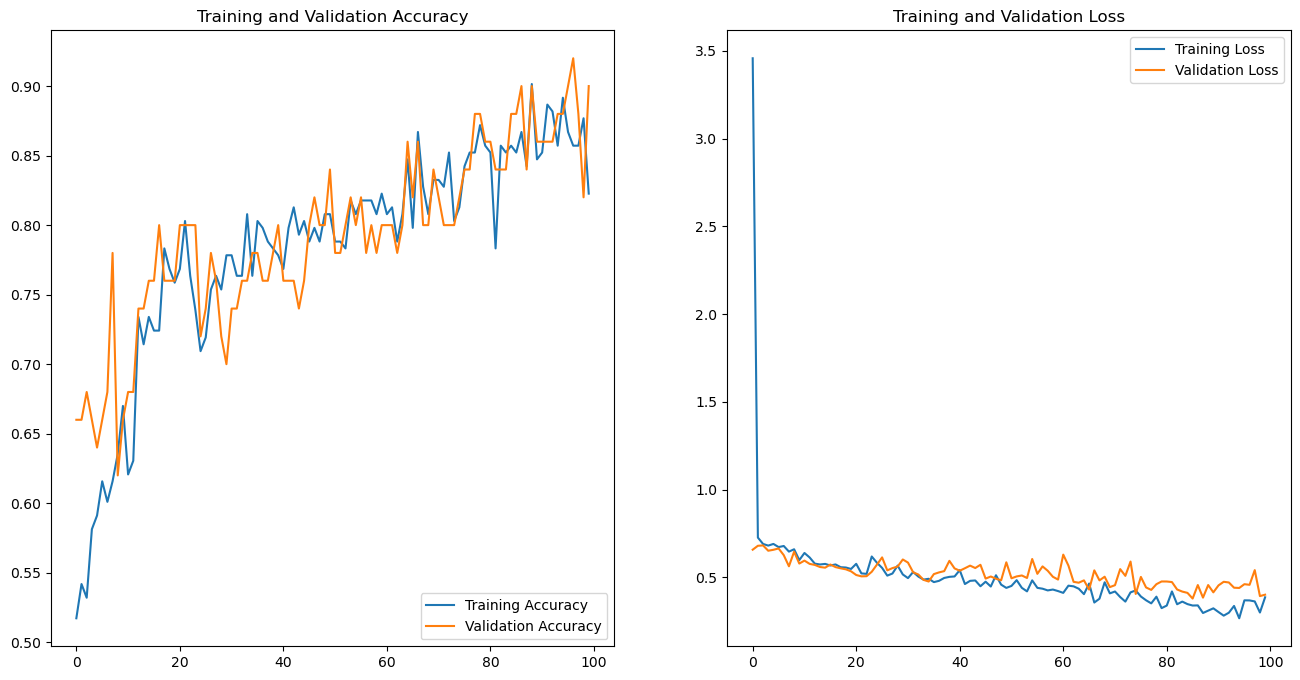

In [15]:
plot_history(history, epochs)

### Making predictions on validation dataset

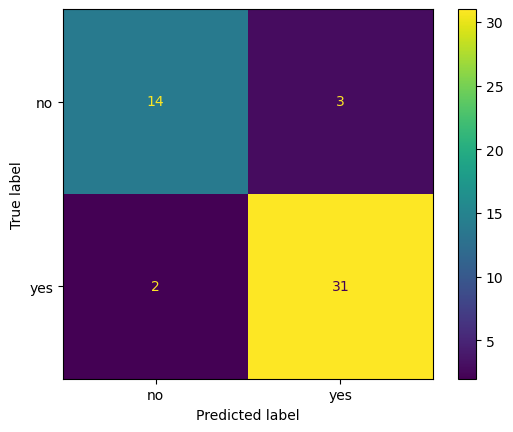

In [16]:
predictions = []
y_true = []
y_pred = []

predictions = model.predict(val_dt, verbose=0)
for prediction in predictions:
    score = tf.nn.softmax(prediction)
    y_pred.append(np.argmax(score))
    
for X, y in val_dt.as_numpy_iterator():  
    y_true.extend(y)  

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot()

In [17]:
show_metrics(y_true, y_pred)

,Accuracy,Recall,Precision,F1-Score
0,0.9,0.939394,0.911765,0.925373


Well, its seems a good result but if we make predictions with images that model never have seen, will we have good predictions?

## 📂 Using other similar dataset to test my model.

The [Brain tumor MRI dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset) is other dataset that contain multiple scans of different type tumors, but this dataset is more than large that before dataset and its contain MRI scans of several angles and positions. I selected to test my model some scans with axial plane at the parietal region. Let's see one image and let's make the prediction.

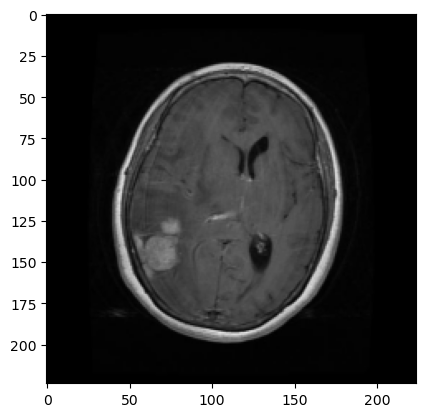

In [18]:
img_test = cv2.resize(cv2.imread('/kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-meTr_0006.jpg'), (224, 224), interpolation=cv2.INTER_AREA)
plt.imshow(img_test)

In [19]:
predictions = model.predict(tf.expand_dims(img_test, 0))
score = tf.nn.softmax(predictions[0])
class_names[np.argmax(score)]

1/1 [==============================] - 0s 251ms/step


'no'

Oops! This is terrible, this image show a brain with meningioma brain, a kind of tumor. Let's make more predictions to know the model's performance.

### Making predictions on the new test dataset
The class names in the dataset is either 'yes' or 'no', therefore we have to do a transformation on the new class names on the new test dataset in such that:

- **'glioma', 'meningioma', and 'pituitary' -> 'yes'**
- **'notumor' -> 'no'**

In [20]:
image_dir_test = pathlib.Path("/kaggle/input/brain-tumor-mri-dataset/Testing")
test_dt = image_dataset_from_directory(
    directory = image_dir_test,
    batch_size = 32,
    image_size = (224, 224),
    seed = 42)

Found 1311 files belonging to 4 classes.


In [21]:
test_dt.class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

In [22]:
test_dt = test_dt.cache().prefetch(buffer_size=AUTOTUNE)

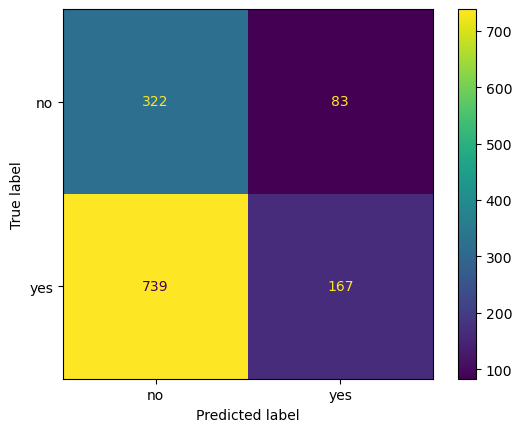

In [23]:
predictions = []
y_true = []
y_pred = []

predictions = model.predict(test_dt, verbose=0)
for prediction in predictions:
    score = tf.nn.softmax(prediction)
    y_pred.append(np.argmax(score))
     
for X, y in test_dt.as_numpy_iterator():  
    y_true.extend(y)

y_true_trans = [1 if i == 0 or i == 1 or i == 3 else 0 for i in y_true]   
    
cm = confusion_matrix(y_true_trans, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["no", "yes"])
disp.plot()

In [24]:
metrics1 = show_metrics(y_true_trans, y_pred)
metrics1

,Accuracy,Recall,Precision,F1-Score
0,0.372998,0.184327,0.668,0.288927


Oh no! We have terrible news, my model's performance is too bad when we make predictions on new images. Therefore, we have two options, we change the model and adjust the hyperparameters of model or we use transfer learning. I did many changes on the model and I could not improve the performance for what I chose to use transfer learning, let's see how.

# 📥 Using transfer learning with ResNet50 model.

### Looking for the better learning rate

In [25]:
base_model = ResNet50V2(input_shape=(224, 224, 3), include_top=False)
base_model.trainable = False

model_2 = tf.keras.Sequential(layers=[
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomZoom(0.05, 0.05),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),
    
    base_model,
    
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation="softmax")
])

model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

epochs = 50
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

history_2 = model_2.fit(train_dt,
                     epochs=epochs,
                     steps_per_epoch=len(train_dt),
                     callbacks=[lr_scheduler],
                     verbose=0)

94668760/94668760 [==============================] - 1s 0us/step


### Viewing the loss vs the learning rate

Text(0, 0.5, 'Loss')

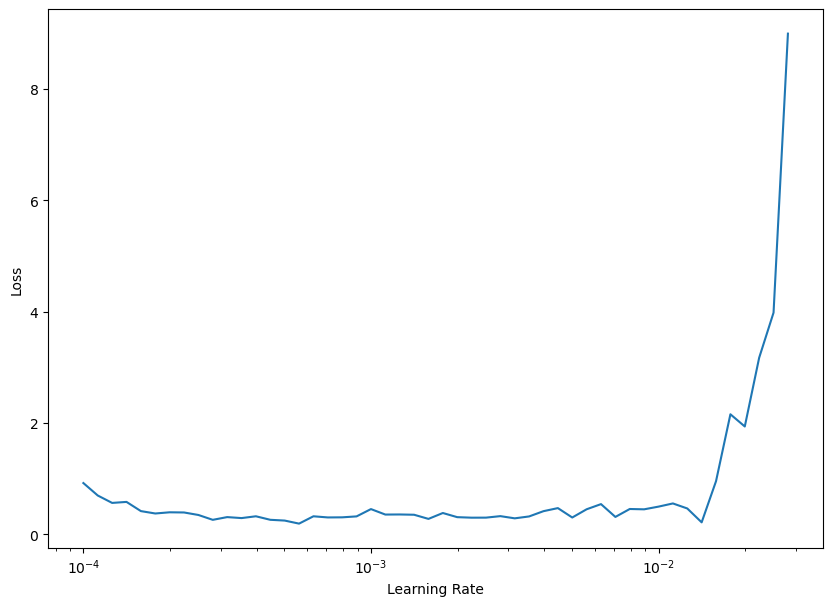

In [26]:
lrs = 1e-4 * (10 ** (np.arange(epochs)/20))
plt.figure(figsize=(10,7))
plt.semilogx(lrs, history_2.history['loss'])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')

In [27]:
minimum = min(history_2.history['loss'])
index = history_2.history['loss'].index(minimum)
lr = lrs[index]
print("The better learning rate is", lr)

The better learning rate is 0.0005623413251903491


## 🦾 Training the model with ResNet50 model

In [28]:
base_model = ResNet50V2(input_shape=(224, 224, 3), include_top=False)
base_model.trainable = False

model_2 = tf.keras.Sequential(layers=[
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomZoom(0.05, 0.05),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation="softmax")
])

model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(lr=lr),
               metrics=["accuracy"])

epochs = 50
history_2 = model_2.fit(train_dt,
                     validation_data=val_dt,
                     epochs=epochs,
                     steps_per_epoch=len(train_dt),
                     validation_steps=len(val_dt),
                     verbose=2)

Epoch 1/50
7/7 - 8s - loss: 1.0913 - accuracy: 0.5911 - val_loss: 0.3670 - val_accuracy: 0.8600 - 8s/epoch - 1s/step
Epoch 2/50
7/7 - 0s - loss: 0.6183 - accuracy: 0.7635 - val_loss: 0.4312 - val_accuracy: 0.8000 - 454ms/epoch - 65ms/step
Epoch 3/50
7/7 - 0s - loss: 0.5079 - accuracy: 0.7980 - val_loss: 0.4187 - val_accuracy: 0.8000 - 455ms/epoch - 65ms/step
Epoch 4/50
7/7 - 0s - loss: 0.4896 - accuracy: 0.7980 - val_loss: 0.3099 - val_accuracy: 0.8800 - 456ms/epoch - 65ms/step
Epoch 5/50
7/7 - 0s - loss: 0.4823 - accuracy: 0.8276 - val_loss: 0.3387 - val_accuracy: 0.8800 - 452ms/epoch - 65ms/step
Epoch 6/50
7/7 - 0s - loss: 0.4723 - accuracy: 0.8227 - val_loss: 0.4359 - val_accuracy: 0.8600 - 455ms/epoch - 65ms/step
Epoch 7/50
7/7 - 0s - loss: 0.3748 - accuracy: 0.8374 - val_loss: 0.3116 - val_accuracy: 0.8200 - 452ms/epoch - 65ms/step
Epoch 8/50
7/7 - 0s - loss: 0.4192 - accuracy: 0.8621 - val_loss: 0.3278 - val_accuracy: 0.8800 - 455ms/epoch - 65ms/step
Epoch 9/50
7/7 - 0s - loss: 0

### Viewing the accuracy and the loss for each epoch between training and validation.

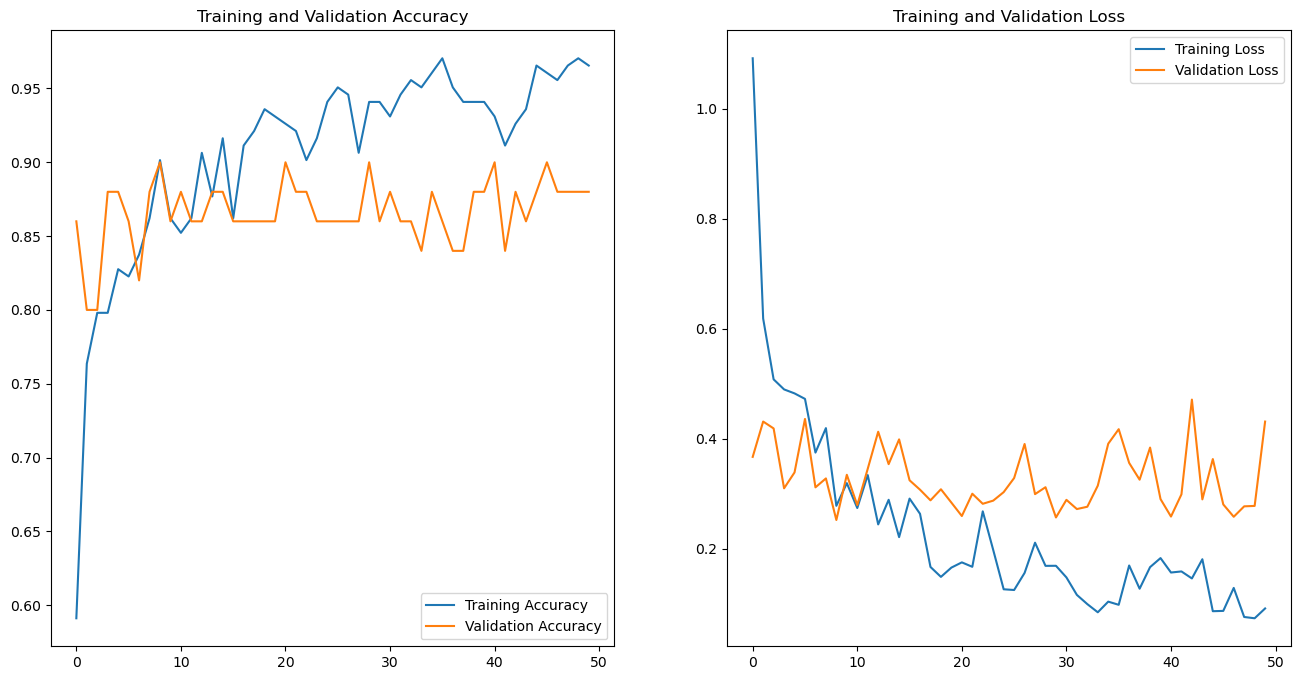

In [29]:
plot_history(history_2, epochs)

### Making predictions on new images

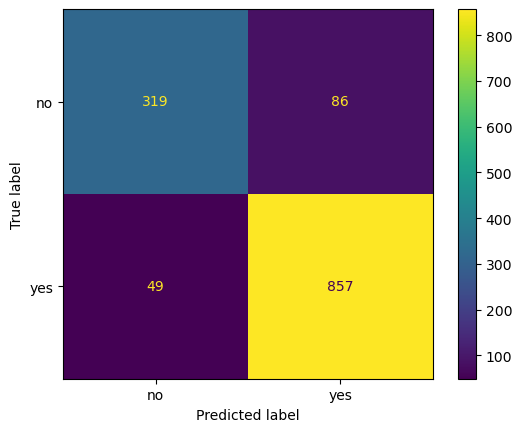

In [30]:
predictions = []
y_true = []
y_pred = []

predictions = model_2.predict(test_dt, verbose=0)
for prediction in predictions:
    score = tf.nn.softmax(prediction)
    y_pred.append(np.argmax(score))
     
for X, y in test_dt.as_numpy_iterator():  
    y_true.extend(y)

y_true_trans = [1 if i == 0 or i == 1 or i == 3 else 0 for i in y_true]   
    
cm = confusion_matrix(y_true_trans, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["no", "yes"])
disp.plot()

In [31]:
metrics2 = show_metrics(y_true_trans, y_pred)
metrics2

,Accuracy,Recall,Precision,F1-Score
0,0.897025,0.945916,0.908802,0.926988


Okey, the model's performance is better than my old model, but it isn't enough. We have many fails predictions. We can try to change the model or tune the hyperparameters but we won't be able to improve the model's accuracy much further because this dataset is too small and we need more samples to improve the model's accuracy.

# 🧠 About [Brain tumor MRI dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)

This dataset contains 7023 images of human brain MRI images which are classified into 4 classes: glioma - meningioma - no tumor and pituitary. No tumor class images were taken from the Br35H dataset.

This dataset contain more samples than old dataset, this can to improve the model's accuracy.

# 💻 Creation of training, validation and test dataset from images

In [32]:
image_dir_train = pathlib.Path("/kaggle/input/brain-tumor-mri-dataset/Training/")
train2_dt, val2_dt = image_dataset_from_directory(
    directory = image_dir_train,
    batch_size = 32,
    image_size = (224, 224),
    subset = "both",
    validation_split = 0.2,
    seed = 42)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Using 1142 files for validation.


The training dataset contain 4570 images this is a better amount of samples and the validation dataset contain 1142 images, excellent.

## Class names starting of directories tree

In [33]:
class_names = train2_dt.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [34]:
AUTOTUNE = tf.data.AUTOTUNE

train2_dt = train2_dt.cache().prefetch(buffer_size=AUTOTUNE)
val2_dt = val2_dt.cache().prefetch(buffer_size=AUTOTUNE)

## Looking for the better learning rate

In [35]:
model_5 = tf.keras.Sequential(layers=[
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomZoom(0.05, 0.05),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, activation="relu"),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=(1,1), padding="valid"),

    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=(1,1)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation="relu"),

    tf.keras.layers.Dense(4, activation="softmax")
])

model_5.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(),
             metrics=["accuracy"])

epochs = 50     
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))
  
history_5 = model_5.fit(train2_dt,
                      epochs=epochs,
                      steps_per_epoch=len(train2_dt),
                      callbacks=[lr_scheduler],
                      verbose=0)

### Viewing the loss vs the learning rate

Text(0, 0.5, 'Loss')

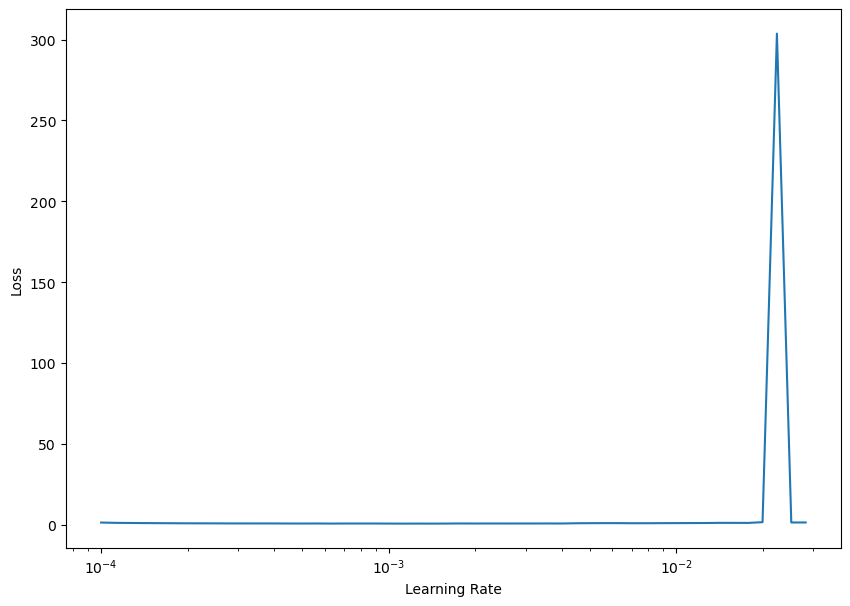

In [36]:
lrs = 1e-4 * (10 ** (np.arange(epochs)/20))
plt.figure(figsize=(10,7))
plt.semilogx(lrs, history_5.history['loss'])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')

In [37]:
minimum = min(history_5.history['loss'])
index = history_5.history['loss'].index(minimum)
lr = lrs[index]
print("The better learning rate is", lr)

The better learning rate is 0.0014125375446227542


## 🤖 Training my own deep learning model with preprocess layers to data augmentation:

In [38]:
model_5 = tf.keras.Sequential(layers=[
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomZoom(0.05, 0.05),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, activation="relu"),
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=(1,1)),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=(1,1)),

    tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu"),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=(1,1)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation="relu"),

    tf.keras.layers.Dense(4, activation="softmax")
])

model_5.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             optimizer=tf.keras.optimizers.Adam(lr=lr),
             metrics=["accuracy"])

epochs = 100 
history_5 = model_5.fit(train2_dt,
                     validation_data=val2_dt,
                     epochs=epochs,
                     steps_per_epoch=len(train2_dt),
                     validation_steps=len(val2_dt),
                     verbose=2)

Epoch 1/100
143/143 - 31s - loss: 1.3702 - accuracy: 0.4298 - val_loss: 1.1082 - val_accuracy: 0.5385 - 31s/epoch - 215ms/step
Epoch 2/100
143/143 - 21s - loss: 1.0272 - accuracy: 0.5937 - val_loss: 0.8580 - val_accuracy: 0.6585 - 21s/epoch - 145ms/step
Epoch 3/100
143/143 - 21s - loss: 0.9002 - accuracy: 0.6492 - val_loss: 0.7044 - val_accuracy: 0.7320 - 21s/epoch - 145ms/step
Epoch 4/100
143/143 - 21s - loss: 0.8408 - accuracy: 0.6744 - val_loss: 0.9092 - val_accuracy: 0.6366 - 21s/epoch - 145ms/step
Epoch 5/100
143/143 - 21s - loss: 0.8085 - accuracy: 0.6818 - val_loss: 1.2209 - val_accuracy: 0.5753 - 21s/epoch - 145ms/step
Epoch 6/100
143/143 - 21s - loss: 0.7910 - accuracy: 0.6904 - val_loss: 1.1380 - val_accuracy: 0.6042 - 21s/epoch - 145ms/step
Epoch 7/100
143/143 - 21s - loss: 0.7461 - accuracy: 0.7153 - val_loss: 0.7493 - val_accuracy: 0.7242 - 21s/epoch - 145ms/step
Epoch 8/100
143/143 - 21s - loss: 0.7213 - accuracy: 0.7219 - val_loss: 0.6655 - val_accuracy: 0.7513 - 21s/epo

### Viewing the accuracy and the loss for each epoch between training and validation.

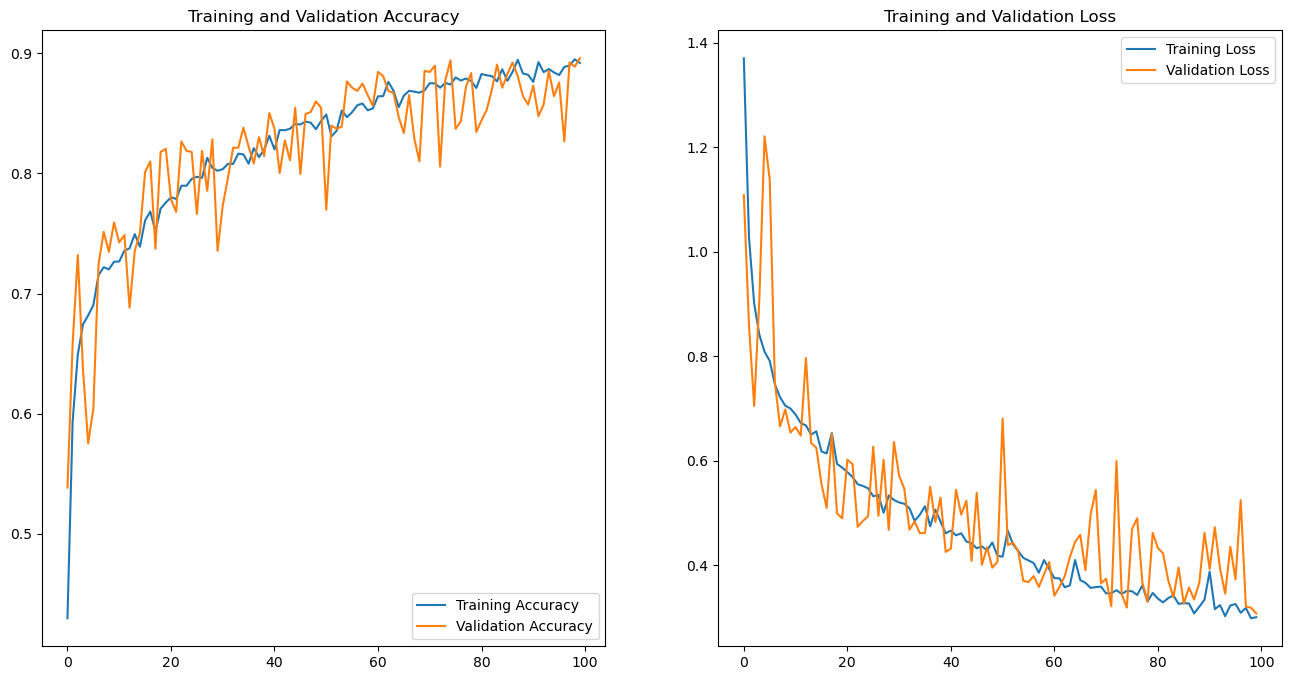

In [39]:
plot_history(history_5, epochs)

### Making predictions on test dataset

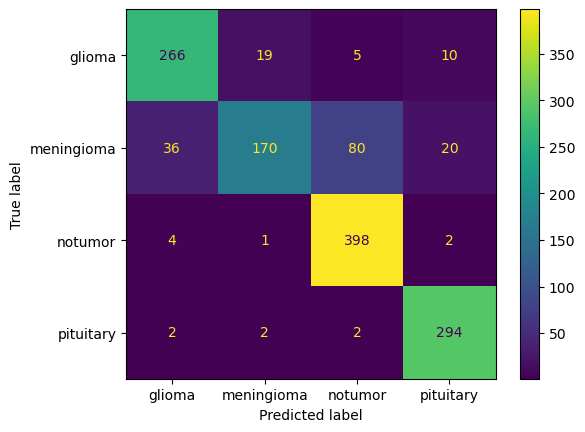

In [40]:
predictions = []
y_true = []
y_pred = []

predictions = model_5.predict(test_dt, verbose=0)
for prediction in predictions:
    score = tf.nn.softmax(prediction)
    y_pred.append(np.argmax(score))
    
for X, y in test_dt.as_numpy_iterator():  
    y_true.extend(y)
    
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot()

In [41]:
metrics3 = show_metrics(y_true, y_pred)
metrics3

,Accuracy,Recall,Precision,F1-Score
0,0.860412,0.958457,0.966102,0.962264


Yes! This look better but, and if we use transfer learning?

# 📥 Using transfer learning with ResNet50 model.

## Looking for the better learning rate

In [42]:
base_model = ResNet50V2(input_shape=(224, 224, 3), include_top=False)
base_model.trainable = False

model_4 = tf.keras.Sequential(layers=[
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomZoom(0.05, 0.05),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation="softmax")
])

model_4.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

epochs = 50

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

history_4 = model_4.fit(train2_dt,
                     epochs=epochs,
                     steps_per_epoch=len(train2_dt),
                     callbacks=[lr_scheduler],
                     verbose=0)

### Viewing the loss vs the learning rate

Text(0, 0.5, 'Loss')

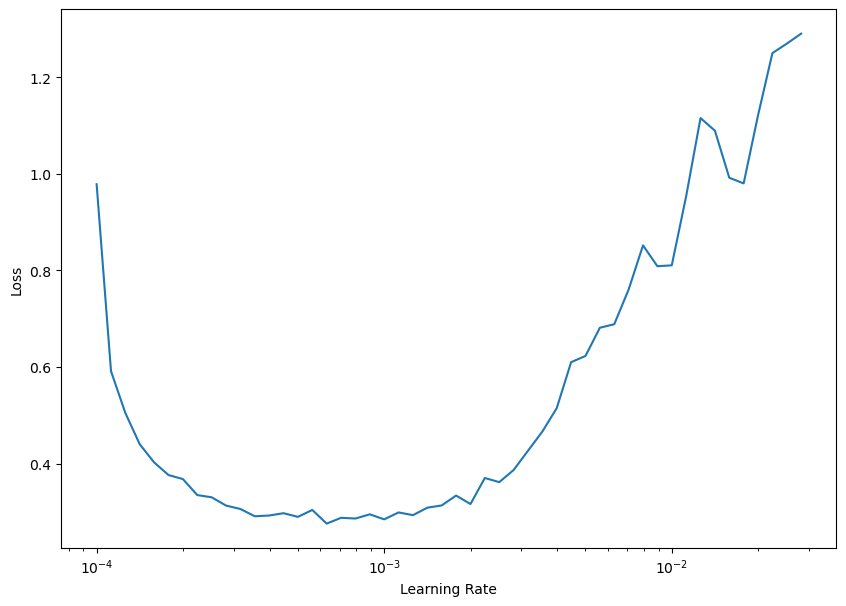

In [43]:
lrs = 1e-4 * (10 ** (np.arange(epochs)/20))
plt.figure(figsize=(10,7))
plt.semilogx(lrs, history_4.history['loss'])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')

In [44]:
minimum = min(history_4.history['loss'])
index = history_4.history['loss'].index(minimum)
lr = lrs[index]
print("The better learning rate is", lr)

The better learning rate is 0.0006309573444801934


## Training the model with ResNet50 model

In [45]:
base_model = ResNet50V2(input_shape=(224, 224, 3), include_top=False)
base_model.trainable = False

model_4 = tf.keras.Sequential(layers=[
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomZoom(0.05, 0.05),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation="softmax")
])

model_4.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(lr=lr),
               metrics=["accuracy"])

epochs = 125
history_4 = model_4.fit(train2_dt,
                     validation_data=val2_dt,
                     epochs=epochs,
                     steps_per_epoch=len(train2_dt),
                     validation_steps=len(val2_dt),
                     verbose=2)

Epoch 1/125
143/143 - 16s - loss: 0.7929 - accuracy: 0.7155 - val_loss: 0.4435 - val_accuracy: 0.8363 - 16s/epoch - 114ms/step
Epoch 2/125
143/143 - 10s - loss: 0.4754 - accuracy: 0.8311 - val_loss: 0.3985 - val_accuracy: 0.8546 - 10s/epoch - 68ms/step
Epoch 3/125
143/143 - 10s - loss: 0.4136 - accuracy: 0.8525 - val_loss: 0.3546 - val_accuracy: 0.8739 - 10s/epoch - 69ms/step
Epoch 4/125
143/143 - 10s - loss: 0.3761 - accuracy: 0.8567 - val_loss: 0.3569 - val_accuracy: 0.8739 - 10s/epoch - 68ms/step
Epoch 5/125
143/143 - 10s - loss: 0.3639 - accuracy: 0.8698 - val_loss: 0.3411 - val_accuracy: 0.8827 - 10s/epoch - 68ms/step
Epoch 6/125
143/143 - 10s - loss: 0.3393 - accuracy: 0.8805 - val_loss: 0.3167 - val_accuracy: 0.8932 - 10s/epoch - 68ms/step
Epoch 7/125
143/143 - 10s - loss: 0.3110 - accuracy: 0.8825 - val_loss: 0.2978 - val_accuracy: 0.8949 - 10s/epoch - 67ms/step
Epoch 8/125
143/143 - 10s - loss: 0.3028 - accuracy: 0.8888 - val_loss: 0.2951 - val_accuracy: 0.8975 - 10s/epoch - 6

### Viewing the accuracy and the loss for each epoch between training and validation.

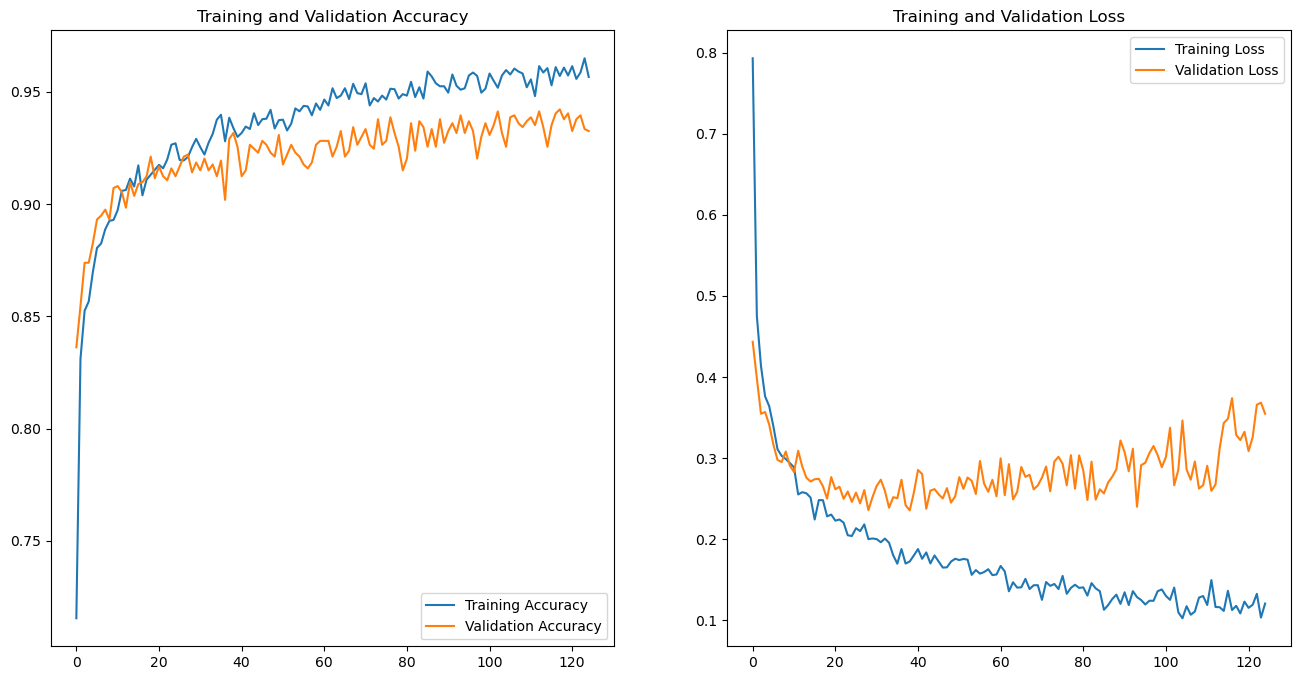

In [46]:
plot_history(history_4, epochs)

### Making predictions on test dataset

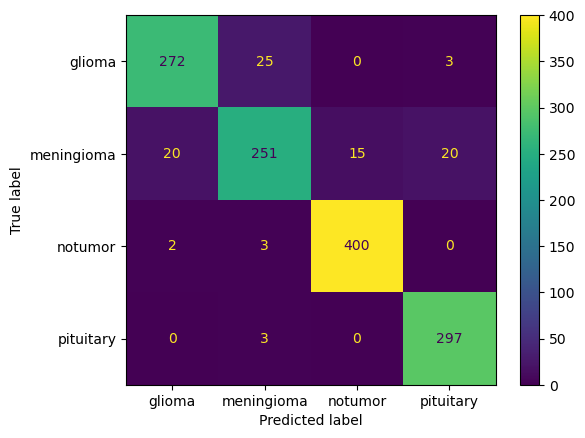

In [47]:
predictions = []
y_true = []
y_pred = []

predictions = model_4.predict(test_dt, verbose=0)
for prediction in predictions:
    score = tf.nn.softmax(prediction)
    y_pred.append(np.argmax(score))
    
for X, y in test_dt.as_numpy_iterator():  
    y_true.extend(y)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot()

In [48]:
metrics4 = show_metrics(y_true, y_pred)
metrics4

,Accuracy,Recall,Precision,F1-Score
0,0.930587,0.978239,0.972468,0.975345


## 🔎 Showing predictions

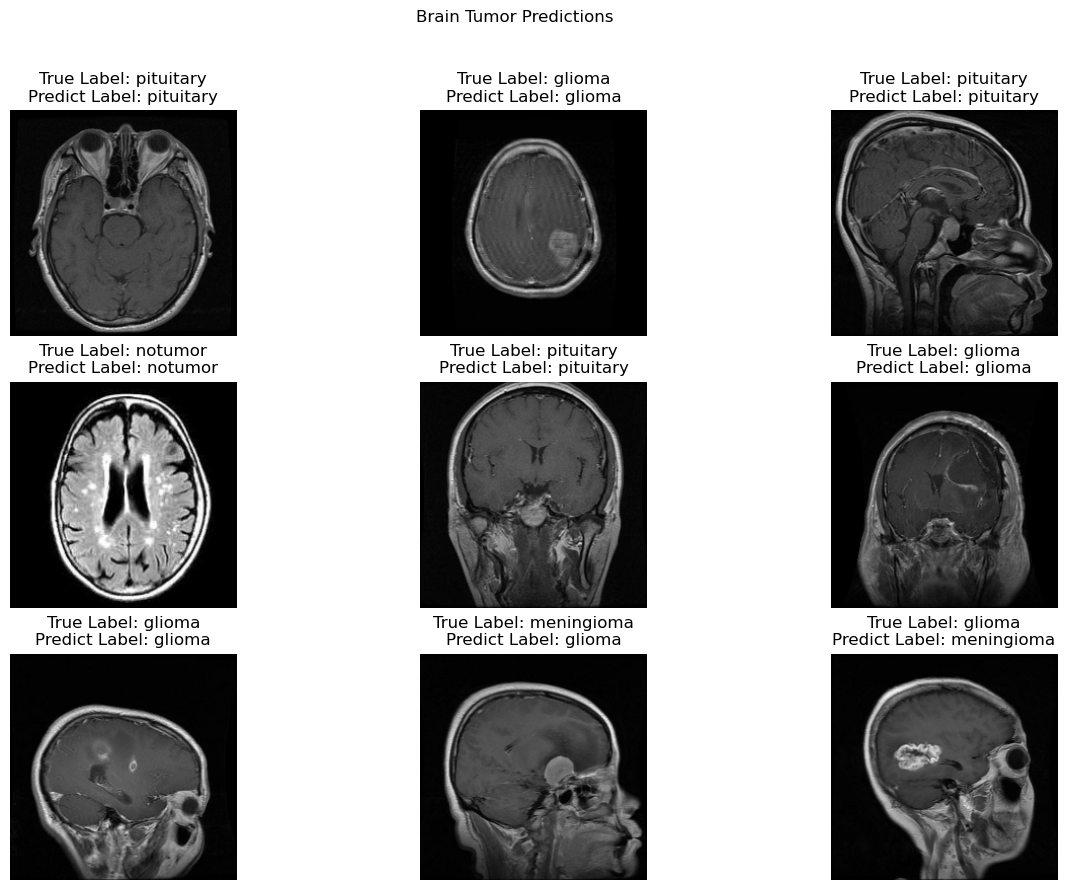

In [49]:
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Brain Tumor Predictions')
for images, labels in test_dt.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f'True Label: {class_names[labels[i]]}\nPredict Label: {class_names[y_pred[i]]}')
    plt.axis("off")

# 📣 Conclusion
Let's compare the models metrics:

In [50]:
metric_values = [metrics1.iloc[0].tolist(), metrics2.iloc[0].tolist(), metrics3.iloc[0].tolist(), metrics4.iloc[0].tolist()]
resume = pd.DataFrame(data=metric_values, columns=["Accuracy", "Recall", "Precision", "F1-Score"], index=["MyModel training w/ First Dataset", "ResNet50 training w/ First Dataset", "MyModel training w/ Second Dataset", "ResNet50 training w/ Second Dataset"])
resume.style.highlight_max(color = 'green', axis = 0)

,Accuracy,Recall,Precision,F1-Score
MyModel training w/ First Dataset,0.372998,0.184327,0.668000,0.288927
ResNet50 training w/ First Dataset,0.897025,0.945916,0.908802,0.926988
MyModel training w/ Second Dataset,0.860412,0.958457,0.966102,0.962264
ResNet50 training w/ Second Dataset,0.930587,0.978239,0.972468,0.975345


In order to improve the performance of our models, it was necessary to adjust the hyperparameters correctly, use data augmentation, use transfer-learning and obtain a greater number of samples for training.